# Supervised text analysis using Doc2Vec vectors on twitter data

We import necessary libs

*Codes related to data cleaning have been places in a seperate functions.py file*

In [23]:
import pandas as pd
import nltk
from tqdm import tqdm
from gensim.models.doc2vec import TaggedDocument,Doc2Vec
from functions import data_cleaner_tweets
from functions import data_cleaner
from functions import tokenize_text
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,plot_roc_curve
import matplotlib.pyplot as plt

We use the famous sentiment140 dataset with over 1.6 million tweets.

We pick up the sentiment column and the tweet column. (0-Negative,1-Positive).

dataset link : https://www.kaggle.com/kazanova/sentiment140

In [27]:
df = pd.read_csv(r'../Datasets/labeled_tweets.csv',engine='python',usecols=[0,5],names=['sentiment','tweet'])
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


We clean the data using the functions which is present in functions.py file

1.Using demoji to remove emojis that might be along with the texts.

2.Using re library to handle special chars and handle names,hyperlinks.

In [ ]:
df.tweet = data_cleaner(df.tweet)
df.tweet = data_cleaner_tweets(df.tweet)

Next up we use Gensim's TaggedDocument setup to transfom the data set that can be fed into Doc2Vec model.

The Tagged document has 2 parts:
1. words : this is the tokenised list of words i.e our tweets
2. tags: this will be the target varialbles. In this cases the sentiments.

For more about Taggedocument and Doc2Vec model, checkout link below:

https://radimrehurek.com/gensim/models/doc2vec.html

We use nltk to tokenize the words

Example of a TaggedDocument : TaggedDocument(words=['spring', 'break', 'in', 'plain', 'city', 'it', 'snowing'], tags=[0])

In [4]:
dataset = []
def f_docbuilder(x,y):
    for i in range(len(x)):
        dataset.append(TaggedDocument(words=tokenize_text(x[i]), tags=[y[i]] ))

Using the abouve function we create the dataset in the necessary format, initialize the Doc2Vec model and split the data.

In [6]:
f_docbuilder(df.tweet,df.sentiment)
doc_model = Doc2Vec(vector_size=50, min_count=2, epochs=20)
train_docs,test_docs = train_test_split(dataset,test_size=0.2)
doc_model.build_vocab([x for x in tqdm(train_docs)])

100%|███████████████████████████████████████████████████████████████████| 1280000/1280000 [00:00<00:00, 2506689.20it/s]


The data is then converted to vectors i.e numerical values which can be used in a classifer

In [8]:
train_vecs = [doc_model.infer_vector(train_docs[i].words) for i in range(len(train_docs))]
train_targets = [train_docs[i].tags[0] for i in range(len(train_docs))]
test_vecs = [doc_model.infer_vector(test_docs[i].words) for i in range(len(test_docs))]
test_targets = [test_docs[i].tags[0] for i in range(len(test_docs))]

We use gridsearchcv to find parameters best suited for the dataset

In [16]:
log_params = [{'penalty':['l1','l2'],'fit_intercept':[True,False]}]
grid_search = GridSearchCV(estimator=LogisticRegression(),param_grid=log_params,scoring=['accuracy','roc_auc'],n_jobs=-1,return_train_score=True,refit='roc_auc')
#taking a subset of the training data
s_train_vecs = train_vecs[0:50000]
s_train_targets = train_targets[0:50000]
grid_search_val = grid_search.fit(s_train_vecs,s_train_targets)

In [18]:
grid_search_val.best_params_

{'fit_intercept': True, 'penalty': 'l2'}

We use the params in the LogisticModel, and then train and predict

In [29]:
logreg_model = LogisticRegression(penalty='l2',fit_intercept=True)
logreg_model.fit(X=train_vecs,y=train_targets)
y_pred_logmodel = logreg_model.predict(test_vecs)
test_accuracy = accuracy_score(test_targets,y_pred_logmodel)
train_accuracy = accuracy_score(train_targets,logreg_model.predict(train_vecs))
c_report = classification_report(test_targets,y_pred_logmodel,target_names=['Negative','Positive'])
print(f'LogReg model train accuracy is : {train_accuracy}')
print(f'LogReg model test accuracy is : {test_accuracy}')
print(f'*******************Classification Report******************')
print(c_report)

LogReg model train accuracy is : 0.741465625
LogReg model test accuracy is : 0.696284375
*******************Classification Report******************
              precision    recall  f1-score   support

    Negative       0.71      0.67      0.69    160036
    Positive       0.69      0.72      0.70    159964

    accuracy                           0.70    320000
   macro avg       0.70      0.70      0.70    320000
weighted avg       0.70      0.70      0.70    320000



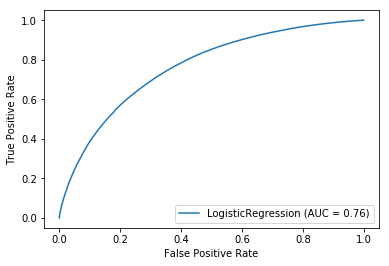

In [24]:
plot_roc_curve(logreg_model,X=test_vecs,y=test_targets)
plt.show()

We could see the metrics above.The model and approach gives us a starting block upon wich furthes improvements can be added.

1. We could still potentially increase the perforamce if we are to implement some Deep Learning model.

2. Over the course using lemmataization decreased the performance and hence was not performed here.